### 项目说明
通过对安居客(西安)的房源情况进行分析, 了解租房现状

### 目的
希望可以根据数据,了解以下几个问题:
1. 房源数量分布情况
2. 房租分布情况
3. 面积分布情况
4. 租金的影响因素
5. 寻找性价比最高的小区

## 文章目录
- 1.数据爬取与导入
- 2.数据清洗
- 3.数据探索
- 3.1 房源基本信息分析
- 3.2 双维度分析
- 3.2.1 分类变量(区域,户型,装修程度,租房类型)与租金的关系
- 3.2.2 连续变量(面积)和租金的关系
- 3.2.3 房源主要聚集地
- 3.3 寻找各区域性价比最高的小区
- 4.思考和总结
- 5.特别说明

## 1.数据爬取与导入

本项目所使用的数据集全部来自[安居客(西安租房)](https://xa.zu.anjuke.com/fangyuan/p1/)前50页数据，通过爬虫工具爬取。采集时间:2018年2月24日

本次爬取信息的时候，主要获得了以下信息：'面积', '房型', '装修', '租金压付', '租金', '楼层', '所属区域', '所在小区', '朝向', '租赁方式',
'类型', '位置', '标题',共13个维度,2874条数据.

In [1]:
#导入相关包
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']}) #seaborn显示中文问题
from matplotlib import pyplot as plt
from matplotlib import gridspec
import re
import jieba
from wordcloud import WordCloud

In [2]:
data = pd.read_csv('anjuke20180224.csv',encoding='utf-8') #导入文件

## 2.数据清洗
取出本次分析需用到的字段并清洗,存放于data_new:

In [3]:
# 新建数据框存储所需数据并进行数据整理

data= data[data['所在小区'].isnull()==0]   # 删除将所在小区为空的行

data_new=pd.DataFrame()
data_new['name']=data['标题']  #取出原始数据标题列
data_new['district']=data['所属区域']   #取出原始数据所属区域列
data_new['room_type']= data.房型.apply(lambda x: x[0:2])   #由于原始数据不整齐,如'1室1厅','1室','一室一厅一卫'等, 呈现多种类型,因此只取x室
data_new['current_floor'] = data['楼层'].str.split('/',expand = True)[0].astype(np.int64)  #取出楼层列并通过spilit取出所在楼层,转化为数值型
data_new['total_floor'] = data['楼层'].str.split('/',expand = True)[1].astype(np.int64)    #取出据楼层列并通过spilit取出总共楼层,转化为数值型

# 为了后续分析的楼层分析, 将楼层信息分类
# 楼层  = 所在楼层/ 总共楼层  若值< 0 ,定义为地下室, 若值<= 1/3 , 定义为低楼层, 若值<=2/3 定义为中楼层, 若值<=1,定义为高楼层,其他则返回None
# 数据中存在总楼层数小于4层,可能为别墅或者独院,将其定义为低楼层
def floor_judge(x,y):
    if x > 0 :
        if y > 4:
            if x/y <= 1/3:
                return '低楼层'
            elif x/y <= 2/3:
                return '中楼层'
            elif x/y <=1:
                return '高楼层'
        else:
            return '低楼层'
    else:
        return '地下室'
# data_new['floor']=(data_new['current_floor']/data_new['total_floor']).apply(floor_judge) # 执行上述函数
data_new['floor']= data_new.apply(lambda x: floor_judge(x['current_floor'],x['total_floor']),axis = 1)

data_new['community']=data['所在小区']   #取出原始数据所属小区列
data_new['place']=data['位置']     #取出原始数据位置列
data_new['direction']=data['朝向']     #取出原始数据朝向列
data_new['decoration']= data['装修']    #取出原始数据装修列
data_new['rent_type'] = data['租赁方式'] 
data_new['rent']= data.租金.apply(lambda x :re.findall('\d+',x )[0]).astype(np.float64)    #使用正则取出数据中的数字,并将其转化为数值型
data_new['area']=data.面积.apply(lambda x :re.findall('\d+',x )[0]).astype(np.float64)     #取出原始数据面积列中的数字, 转化为数值型
data_new['unit_price']= round(data_new['rent']/data_new['area'],2)     #由于租金在很大程度上和面积有关, 因此将租金/面积,得出算单位面积租金
data_new = data_new.drop(['current_floor','total_floor'],axis = 1)
data_new.head() #查看数据

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
0,急租！大会堂软件园丈八北路科技二路科技路旁玫瑰公馆拎包入住！,雁塔,1室,中楼层,易道郡玫瑰公馆,鱼化寨,朝东,豪华装修,整租,1700.0,51.0,33.33
1,航天翼城 经典一室 家具家电齐全 拎包入住 年轻人的优选,长安,1室,低楼层,航天翼城,航天城,朝南,精装修,整租,1300.0,50.0,26.00
2,高新区天地源兰亭坊 6500元 3室2厅2卫 精装修，楼层佳,雁塔,3室,高楼层,天地源兰亭坊,木塔寺公园,南北,精装修,整租,6500.0,161.0,40.37
3,玛雅 体育场嘉怡豪庭 2室急售 拎包住超大阳台 近地铁,碑林,2室,中楼层,嘉怡豪庭,南稍门,朝南,精装修,整租,2800.0,94.0,29.79
4,龙首村地铁口 宫园中央 两室 精装 全配 2700,未央,2室,高楼层,荣民宫园中央,大明宫,南北,精装修,整租,2700.0,92.0,29.35


In [4]:
data_new[data_new['unit_price']<10] #查看单位面积房租<10的房源

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
595,华府新桃园 精装三室两厅 带全部家私 底价3000出租,雁塔,3室,中楼层,华府新桃园,大寨路,朝南,精装修,整租,3000.0,3000.0,1.00
758,高科尚都写字楼392平米 甲.级地暖写字楼 另有车位出租！,雁塔,1室,低楼层,高科尚都,锦业路,南北,精装修,整租,1000.0,392.0,2.55
959,电子城 融侨紫薇馨苑 精装修 部分配 看房有钥匙,雁塔,2室,中楼层,融侨紫薇馨苑,电子城,东南,毛坯,整租,2400.0,2400.0,1.00
1088,萌萌哒、合租单间、带大阳台、带飘窗、带空调、无线覆盖归宿,雁塔,4室,低楼层,中海观园A区,曲江大道,朝南,精装修,整租,850.0,138.0,6.16
1119,汉城路地铁口，全配3居室，拎包入住,莲湖,3室,高楼层,雅卓花园,枣园,南北,简单装修,整租,1300.0,134.0,9.70
1403,大兴医院对面 小三室空房 只租800元,莲湖,3室,中楼层,博文苑,梨园路,东北,简单装修,整租,800.0,88.0,9.09
1476,钟楼开元商城骡马市印花布园小区精美单间白菜价只租700元,碑林,3室,中楼层,印花布园小区,南门,南北,精装修,合租,700.0,96.0,7.29
1604,电视塔 全欧装修 先到先得 豪华装修 拎包即住，随时约看！,雁塔,2室,中楼层,紫郡长安,长安西路,朝南,精装修,合租,850.0,97.0,8.76
1689,竹园 阳光嘉苑 高新国际 精装修 物业完善,雁塔,4室,中楼层,竹园阳光嘉苑,西沣路,南北,简单装修,整租,5000.0,4000.0,1.25
1807,长安步行街 一楼 可做商铺 业主诚租 看房方便,长安,3室,低楼层,五龙世纪苑,长安广场,朝东,毛坯,整租,1000.0,140.0,7.14


共12条数据, 根据常识, 单位面积价格<10明显不合理,可能为中介竞价或原始网站信息填写错误,为了不影响后续分析, 不做修改直接删除

In [5]:
data_new = data_new[data_new['unit_price']>10]#使用数据框切片删除面积>500平方的行

In [6]:
data_new[(data_new['district']=='西安周边')|(data_new['district']=='高陵')]# 查看区域为西安周边和高陵的房源

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
132,2室2厅1卫精装全配 陕师大名校旁 诚心出租1300半年付,西安周边,2室,高楼层,奥林匹克花园北京奥运村,咸阳,南北,精装修,整租,1300.0,82.0,15.85
141,诚心出租着急用钱 世纪大道新新佳园2室带家具 不临街采光好,西安周边,2室,中楼层,新新佳园,咸阳,朝南,精装修,整租,1200.0,76.0,15.79
163,世纪大道 奥林匹克花园 经典公寓 两室两厅,西安周边,2室,中楼层,泰盈奥林匹克花园,咸阳,朝南,精装修,整租,1200.0,47.0,25.53
322,西影路 阳光小区 3室精装全配 拎包入住 业主自住 双气入户,西安周边,3室,高楼层,阳光小区,咸阳,南北,精装修,整租,2200.0,130.0,16.92
583,车城花园 电梯两室 精装 诚意出租！,高陵,2室,中楼层,车城温泉花园,泾河工业园,西北,精装修,整租,1350.0,96.0,14.06
827,马家湾长庆东路 群贤北府 精装两室 拎包入住,高陵,2室,低楼层,汇鑫群贤北府,泾河工业园,南北,精装修,整租,1050.0,92.0,11.41
1236,渭城风景两室一厅自住房诚意出租,高陵,2室,中楼层,渭城风景,泾河工业园,朝北,简单装修,整租,1000.0,92.0,10.87
1416,世纪大道 西咸新区 国润城 品质小区 阳光房 新房出租,西安周边,3室,低楼层,国润城,咸阳,南北,精装修,整租,1700.0,106.0,16.04
1419,诚心出租奥园82平米2室2厅1卫 全新家具家电齐全拎包入住,西安周边,2室,高楼层,奥林匹克花园伦敦奥运村,咸阳,朝南,精装修,整租,1600.0,82.0,19.51
2546,恒大城130平米朝南三居室，全配拎包入住，配置高端，温馨舒适,西安周边,3室,中楼层,恒大城,咸阳,西南,精装修,整租,3500.0,130.0,26.92


观察到:
- 区域为西安周边的房源'place'列皆为咸阳
- 高陵区陕西省关中平原腹地，西安市北部,房源数量仅三条

此类数据不符合本次分析条件, 删除处理

In [7]:
data_new = data_new[(data_new['district']!='西安周边')&(data_new['district']!='高陵')]# 仅取区域不为西安周边和高陵的房源

In [8]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2823 entries, 0 to 2873
Data columns (total 12 columns):
name          2823 non-null object
district      2823 non-null object
room_type     2823 non-null object
floor         2823 non-null object
community     2823 non-null object
place         2823 non-null object
direction     2823 non-null object
decoration    2823 non-null object
rent_type     2823 non-null object
rent          2823 non-null float64
area          2823 non-null float64
unit_price    2823 non-null float64
dtypes: float64(3), object(9)
memory usage: 286.7+ KB


数据清洗后剩余2823条房源信息,包括name , district , room_type , floor , community , place , direction , decoration, rent_type , rent , area , unit_price 共计12个字段

## 3.数据探索

### 3.1 房源基本信息分析
从地区, 户型, 所在楼层, 小区, 朝向, 装修程度,租金,面积8个维度查看数量信息:

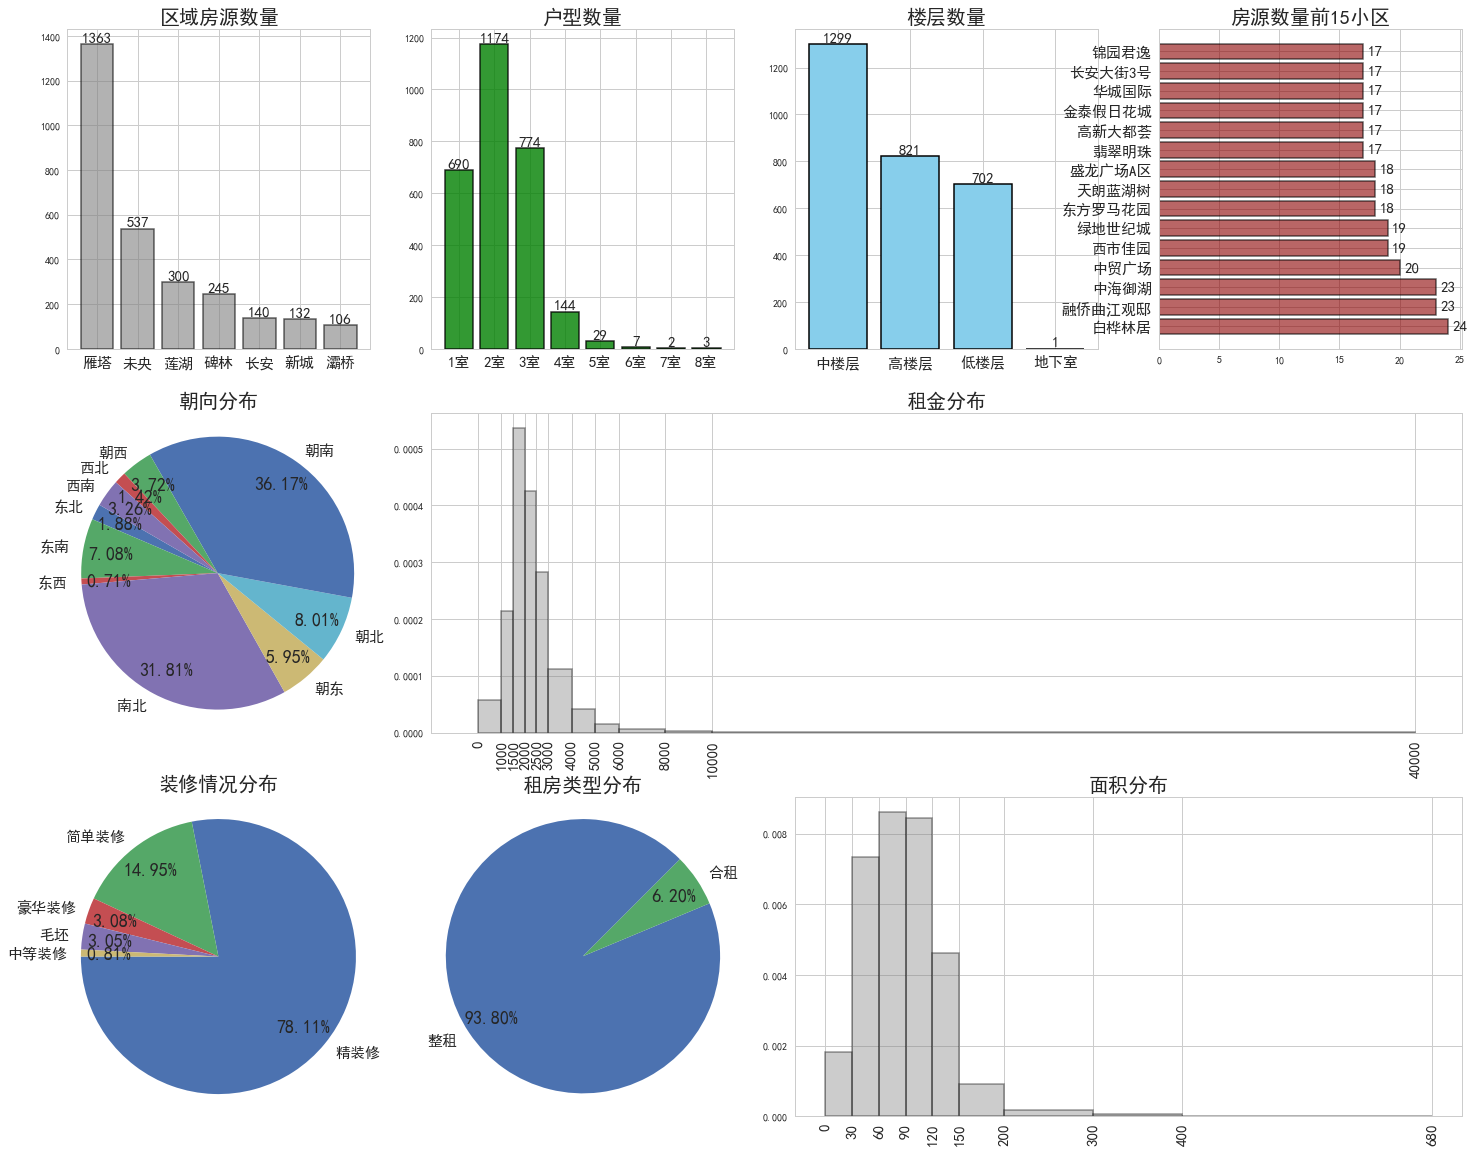

In [9]:
fig = plt.figure(figsize=(25,20))
gs=gridspec.GridSpec(3,4)
ax1=fig.add_subplot(gs[0,0:1])
ax2=fig.add_subplot(gs[0,1:2])
ax3=fig.add_subplot(gs[0,2:3])
ax4=fig.add_subplot(gs[0,3:4])
ax5=fig.add_subplot(gs[1,0:1])
ax6=fig.add_subplot(gs[2,0:1])
ax7=fig.add_subplot(gs[1,1:])
ax8=fig.add_subplot(gs[2,2:])
ax9=fig.add_subplot(gs[2,1:2])

#各个区域的租房数量
district_house_number = data_new['district'].groupby(data_new['district']).count().sort_values(ascending = False)
ax1.bar(np.arange(len(district_house_number)),district_house_number.values,facecolor='gray', alpha=0.6,edgecolor='black',linewidth = 1.5)
ax1.set_xticks(np.arange(len(district_house_number)))
ax1.set_xticklabels(district_house_number.index,fontsize= 15)#,rotation = 90)
ax1.set_title('区域房源数量',fontsize=20)
ax1.grid(True)
for a ,b in zip (np.arange(len(district_house_number)),district_house_number.values):
    ax1.text(a, b + 0.5, '%.0f' % b, ha='center', va= 'bottom',fontsize=15)

#各种户型的租房数量
room_type_house_number = data_new['room_type'].groupby(data_new['room_type']).count()
ax2.bar(np.arange(len(room_type_house_number)),room_type_house_number.values,color = 'g',alpha = 0.8,edgecolor='black',linewidth = 1.5)
ax2.set_xticks(np.arange(len(room_type_house_number)))
ax2.set_xticklabels(room_type_house_number.index,fontsize=15)
ax2.set_title('户型数量',fontsize=20)
ax2.grid(True)
for a ,b in zip (np.arange(len(room_type_house_number)),room_type_house_number.values):
    ax2.text(a, b + 0.5, '%.0f' % b, ha='center', va= 'bottom',fontsize=15)

#房源所在楼层
floor_house_number = data_new['floor'].groupby(data_new['floor']).count().sort_values(ascending = False)
ax3.bar(np.arange(len(floor_house_number)),floor_house_number.values,facecolor= 'skyblue' ,edgecolor='black',linewidth = 1.5)
ax3.set_xticks(np.arange(len(floor_house_number)))
ax3.set_xticklabels(floor_house_number.index,fontsize=15)
ax3.set_title('楼层数量',fontsize=20)
ax3.grid(True)
for a ,b in zip (np.arange(len(floor_house_number)),floor_house_number.values):
    ax3.text(a, b + 0.5, '%.0f' % b, ha='center', va= 'bottom',fontsize=15)

#各个小区的租房数量
community_house_numer = data_new['community'].groupby(data_new['community']).count().sort_values(ascending = False)
ax4.barh(np.arange(len(community_house_numer))[:15],community_house_numer.values[:15],color='darkred',alpha = 0.6,edgecolor='black',linewidth = 1.5)
ax4.set_yticks(np.arange(len(community_house_numer))[:15])
ax4.set_yticklabels(community_house_numer.index[:15],fontsize=15)
ax4.set_title('房源数量前15小区',fontsize=20)
ax4.grid(True)
for a ,b in zip (np.arange(len(community_house_numer))[:15],community_house_numer.values[:15]):
    ax4.text(b+1 ,a , '%.0f' % b, ha='center', va= 'center',fontsize=15)

#朝向分布
direction_house_number = data_new.groupby(['direction'])['direction'].count()
patches, texts, autotexts = ax5.pie(direction_house_number,autopct='%.2f%%',labels= direction_house_number.index,pctdistance=0.8,startangle= 150)
for i in range(0,len(direction_house_number.index)):
    texts[i].set_fontsize(15)
    autotexts[i].set_fontsize(18)
ax5.axis('equal')
ax5.set_title('朝向分布',fontsize=20)

#不同装修情况的租房数量
decoration_house_number = data_new['decoration'].groupby(data_new['decoration']).count().sort_values(ascending = False)
patches, texts, autotexts = ax6.pie(decoration_house_number,autopct='%.2f%%',labels= decoration_house_number.index,pctdistance=0.8,startangle= 180)
ax6.set_title('装修情况分布',fontsize=20)
for i in range(0,len(decoration_house_number.index)):
    texts[i].set_fontsize(15)
    autotexts[i].set_fontsize(18)
ax6.axis('equal')
    
#租金分布
ax7bins = [0,1000,1500,2000,2500,3000,4000,5000,6000,8000,10000,int(data_new['rent'].max())]
ax7.hist(data_new['rent'], bins =ax7bins ,color = 'gray',alpha = 0.4,edgecolor='black',linewidth = 1.5,normed=1)
ax7.set_xticks(ax7bins)
ax7.set_xticklabels(ax7bins,rotation=90,fontsize=15)
ax7.set_title('租金分布',fontsize=20)

#面积分布
ax8bins = [0,30,60,90,120,150,200,300,400,int(data_new['area'].max())]
ax8.hist(data_new['area'], bins =ax8bins,color = 'gray',alpha = 0.4,edgecolor='black',linewidth = 1.5,normed=1)
ax8.set_xticks(ax8bins)
ax8.set_xticklabels(ax8bins,rotation=90,fontsize=15)
ax8.set_title('面积分布',fontsize=20)

#租房类型
rent_type_house_number = data_new['rent_type'].groupby(data_new['rent_type']).count().sort_values(ascending = False)
patches, texts, autotexts = ax9.pie(rent_type_house_number,autopct='%.2f%%',labels= rent_type_house_number.index,pctdistance=0.8,startangle= 45)
ax9.set_title('租房类型分布',fontsize=20)
for i in range(0,len(rent_type_house_number.index)):
    texts[i].set_fontsize(15)
    autotexts[i].set_fontsize(18)
#     autotexts[i].set_color('w')
ax9.axis('equal')


plt.show()

### 小结:
#### 区域房源数量
- 雁塔区房源以1363套占据首位, 占总数的48%. 雁塔区是西安国家级高新技术产业开发区、西安曲江国家级文化产业示范区所在地,区内高校林立、科技领先、人文荟萃、工商业发达,占居榜首理所应当


#### 户型数量
- 绝大部分房屋为3室及以下, 占总数的93%

#### 楼层分布
- 中楼层房源最多,1299条, 占总数的46%
- 高楼层房源和低楼层房源数量相当

#### 小区分布
- 白桦林居以24条房源排在首位，该小区位于西安经济技术开发区，周边配套设施完善
- 融侨曲江观邸和中海御湖各有23条房源,皆位于雁塔区

#### 朝向分布
- 朝南的房源与南北通透房源占到总房源的68%,共1919条
- 东西朝向的房源仅20条,符合常理

#### 装修情况分布
- 精装修房屋站到总数的78%

#### 租房类型分布
- 整租房达到94%

#### 租金分布
- 租金分布明显右偏,大多数集中在1000-3000元/月,最低为280元/月,最高为40000元/月
- 房租平均数为:2631元/月
- 房租中位数为:2100元/月

#### 面积分布
- 面积分布明显右偏, 面积集中在30-120m<sup>2</sup>
- 面积平均数为:90m<sup>2</sup>
- 面积中位数为:88m<sup>2</sup>

查看房租最高和最低的房源:

In [10]:
data_new[data_new['rent']==data_new['rent'].max()]#房租最高的房源

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
1951,公园旁 钻石王朝独栋别墅 豪装全配 品质 拎包入住,雁塔,6室,低楼层,钻石半岛(公寓),雁塔南路,南北,毛坯,整租,40000.0,400.0,100.0


In [11]:
data_new[data_new['rent']==data_new['rent'].min()]#租金最低的房源

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
181,鱼化寨邮局空房出租，有好礼相送！,雁塔,1室,低楼层,鱼化小区,鱼化寨,朝东,精装修,整租,280.0,25.0,11.2
2392,鱼化寨邮局空房出租，有好礼相送！,雁塔,1室,低楼层,鱼化小区,鱼化寨,朝西,简单装修,整租,280.0,20.0,14.0


查看面积最大和最小的房源:

In [12]:
data_new[data_new['area']==data_new['area'].max()]#面积最大的房源

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
1359,锦绣唐朝联排别墅 可办公 看房方便,雁塔,6室,低楼层,锦绣唐朝,大唐芙蓉园,南北,精装修,整租,30000.0,680.0,44.12


In [13]:
data_new[data_new['area']==data_new['area'].min()]#面积最小的房源

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
1250,锦业路可月租，月付，月签合租单间出租，押金200元！,雁塔,5室,低楼层,罗马景福城,锦业路,朝东,精装修,合租,450.0,8.0,56.25


## 3.2  双维度分析

### 3.2.1 分类变量(区域,户型,装修程度,租房类型)与租金的关系

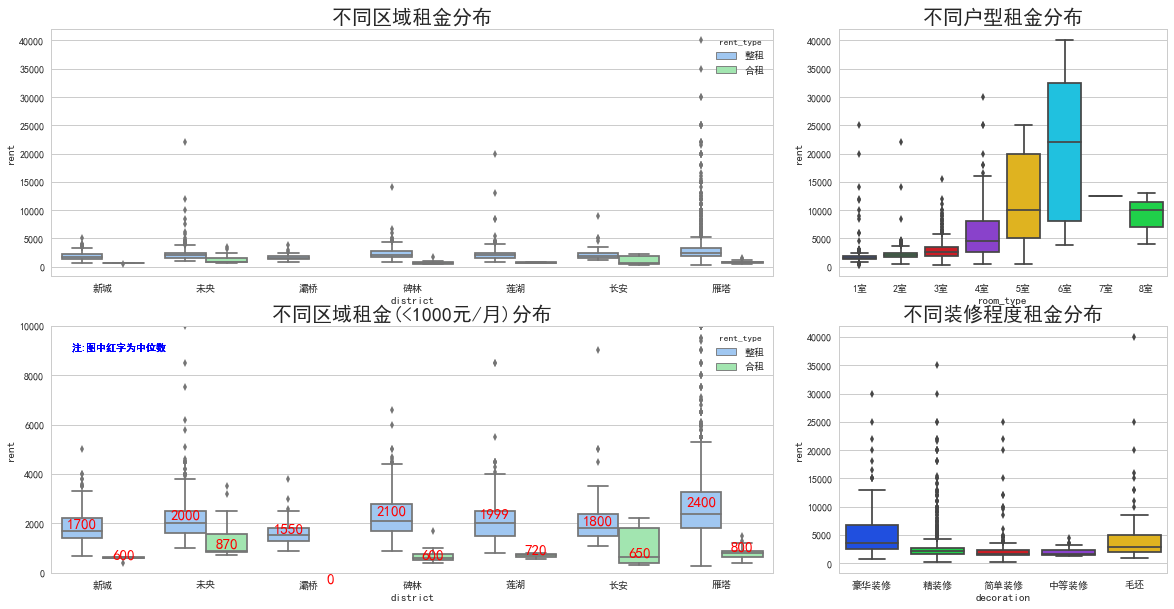

In [14]:
fig2 = plt.figure(figsize = (20,10))

gs=gridspec.GridSpec(2,3)
ax1=fig2.add_subplot(gs[0:1,0:2])
ax2=fig2.add_subplot(gs[0,2:3])
ax3=fig2.add_subplot(gs[1,2:3])
ax4=fig2.add_subplot(gs[1:2,0:2])

#区域和租金
od = data_new.groupby(['district','rent_type'])['rent'].median().unstack().index
sns.boxplot(x= data_new['district'],y= data_new['rent'],hue = data_new['rent_type'],data = data_new,palette= 'pastel',order = od,ax = ax1)
ax1.set_title('不同区域租金分布',fontsize = 20)

#户型和租金
sns.boxplot(x= data_new['room_type'],y= data_new['rent'],data = data_new,order=room_type_house_number.index ,palette= 'bright',ax = ax2)
ax2.set_title('不同户型租金分布',fontsize = 20)

#装修程度和租金
sns.boxplot(x= data_new['decoration'],y= data_new['rent'],data = data_new,palette= 'bright',ax = ax3)
ax3.set_title('不同装修程度租金分布',fontsize = 20)

#区域与租金分布中存在异常值,看不清数据,将租金限定为10000元/月之下,重新作图
ax4.set_title('不同区域租金(<1000元/月)分布',fontsize = 20)
ax4.set_ylim(0,10000)
m1 = data_new.groupby(['district','rent_type'])['rent'].median().unstack().values.T[0]
m1[np.isnan(m1)]=0
m2 = data_new.groupby(['district','rent_type'])['rent'].median().unstack().values.T[1]
sns.boxplot(x= data_new['district'],y= data_new['rent'],hue = data_new['rent_type'],data = data_new,palette= 'pastel',order = od,ax = ax4)
for x,y1,y2 in zip(np.arange(len(m1)),m1,m2):
    plt.text(x+0.2,y1*1.6,'%.0f'%y1,ha='center',va = 'top',fontsize = 15,color='r')
    plt.text(x-0.2,y2*1.3,'%.0f'%y2,ha='center',va = 'top',fontsize = 15,color='r')
    plt.text(-0.3,9000,'注:图中红字为中位数',fontsize= 10,color = 'b')
plt.show()

### 结合原数据作小结:
#### 不同区域租金分布:
- 雁塔区合租房最多,其次为碑林区
- 雁塔区整租房最多,其次为未央区
- 灞桥区全部为整租房源
- 各区域大多数房源租金小于5000元/月
- 整租房源雁塔区租金跨度最大,且房租中位数最高,为2400元/月,房租中位数最低为灞桥区, 为1550元/月
- 合租房源租金中位数最高为未央区,870元/月, 最低为碑林区和新城区, 皆为600元/月
- 整租房源租金大约为合租的3倍

#### 不同户型租金分布:
- 5室之下房源:中位数逐步升高
- 6室的房源仅7条数据, 皆位于雁塔区, 大于10000元/月的房源4个, 分别为2处复式房和2处别墅,因此租金偏高
- 7室房源2条,仅标题不同, 其他信息一致, 可能是同一房源
- 8室房源3条,数据量少, 雁塔莲湖未央各一条,位于莲湖区梅苑温泉小区西院的房源仅4000元/月,看上去极具性价比

#### 不同装修程度租金分布:
- 中位数租金从大到小排序为:豪华装修(3500元/月) > 毛坯(2900元/月) > 精装修(2100元/月) > 中等装修(1700元/月) = 简单装修(1700元/月)
- 毛坯房源租金如此之高令人诧异,预览数据发现毛坯房的面积中位数为107m<sup>2</sup>,平均面积为133m<sup>2</sup>, 面积相对较大
- 毛坯房有65%位于雁塔区,地理位置好



In [15]:
data_new[data_new['room_type'] =='6室']#查看6室的房源信息:

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
92,曲江大华高端别墅 整栋出租 舒适宜居 自住办公 小学幼儿园,雁塔,6室,低楼层,大华公园世家(别墅),曲江城市运动公园,南北,毛坯,整租,6000.0,350.0,17.14
785,恒大绿洲 独立家庭影院 土豪式奢华装修 真正的高品质住宅,灞桥,6室,低楼层,恒大绿洲,长乐坡,南北,豪华装修,整租,3800.0,230.0,16.52
787,紫薇永和坊联排别墅 简装带电梯 100平米带超大花园,雁塔,6室,低楼层,紫薇永和坊(公寓),雁塔南路,南北,毛坯,整租,10000.0,404.0,24.75
1093,高新高品质社区 紫薇公园时光 奢华复式 住在公园享受生活,雁塔,6室,高楼层,紫薇公园时光,木塔寺公园,南北,豪华装修,整租,22000.0,357.0,61.62
1359,锦绣唐朝联排别墅 可办公 看房方便,雁塔,6室,低楼层,锦绣唐朝,大唐芙蓉园,南北,精装修,整租,30000.0,680.0,44.12
1475,南湖西岸 南湖一号 洋房复式 精装全配 带露台 配备三个车位,雁塔,6室,高楼层,碧水西岸南湖1号,南湖,南北,精装修,整租,35000.0,440.0,79.55
1951,公园旁 钻石王朝独栋别墅 豪装全配 品质 拎包入住,雁塔,6室,低楼层,钻石半岛(公寓),雁塔南路,南北,毛坯,整租,40000.0,400.0,100.00


In [16]:
data_new[data_new['room_type'] =='7室']#查看7室的房源信息:

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
2125,曲江一期 钻石半岛 品质 拎包入住 会所居家办公民宿均可,雁塔,7室,高楼层,钻石半岛(公寓),雁塔南路,南北,精装修,整租,12500.0,402.0,31.09
2871,雁南三路 品质小区 钻石半岛 七室全配 办公会所居家均可,雁塔,7室,高楼层,钻石半岛(公寓),雁塔南路,南北,精装修,整租,12500.0,402.0,31.09


In [17]:
data_new[data_new['room_type'] =='8室']#查看8室的房源信息:

,name,district,room_type,floor,community,place,direction,decoration,rent_type,rent,area,unit_price
859,外国语学校 大型社区 可做会所 领包入住,未央,8室,高楼层,富苑阳光,市图书馆,南北,豪华装修,整租,10000.0,300.0,33.33
1370,大面积复式房 简装 可当仓库 也可办公 随时看房,莲湖,8室,低楼层,梅苑温泉小区西院,龙首村,西南,简单装修,整租,4000.0,350.0,11.43
2741,御湖一号 整层出租 办公 开公司 带两车位 无敌观景,雁塔,8室,高楼层,中海御湖,大唐芙蓉园,南北,毛坯,整租,13000.0,400.0,32.50


In [18]:
data_new.groupby(data_new['decoration'])['rent'].median().sort_values()#不同装修类型价格中位数

decoration
中等装修    1700.0
简单装修    1700.0
精装修     2100.0
毛坯      2900.0
豪华装修    3500.0
Name: rent, dtype: float64

In [19]:
data_new.groupby(data_new['decoration'])['area'].mean().sort_values()#不同装修类型面积平均数

decoration
精装修      86.703855
简单装修     92.310427
中等装修     96.043478
豪华装修    131.597701
毛坯      132.906977
Name: area, dtype: float64

In [20]:
data_new.groupby(data_new['decoration'])['area'].median().sort_values()#不同装修类型面积中位数

decoration
精装修      86.0
简单装修     89.0
中等装修     98.0
毛坯      106.5
豪华装修    125.0
Name: area, dtype: float64

### 3.2.2 连续变量(面积)和租金的关系

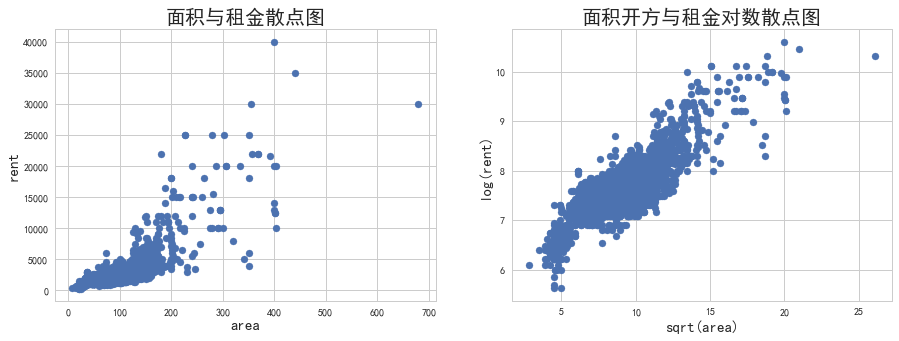

In [21]:
#面积和租金
fig3 = plt.figure(figsize = (15,5))

ax1 = fig3.add_subplot(1,2,1)
ax2 = fig3.add_subplot(1,2,2)

ax1.scatter(data_new['area'],data_new['rent'])
ax1.set_xlabel('area',fontsize = 15)
ax1.set_ylabel('rent',fontsize = 15)
ax1.set_title('面积与租金散点图',fontsize = 20)
ax2.scatter(np.sqrt(data_new['area']),np.log(data_new['rent']))
ax2.set_xlabel('sqrt(area)',fontsize = 15)
ax2.set_ylabel('log(rent)',fontsize = 15)
ax2.set_title('面积开方与租金对数散点图',fontsize = 20)
plt.show()

In [22]:
np.corrcoef(data_new['area'],data_new['rent'])

array([[ 1.        ,  0.77577446],
       [ 0.77577446,  1.        ]])

In [23]:
np.corrcoef(np.sqrt(data_new['area']),np.log(data_new['rent']))

array([[ 1.       ,  0.8316143],
       [ 0.8316143,  1.       ]])

### 小结: 
#### 面积和租金的关系
- 大多数房源为200平方之下,月租金10000之下
- 皮尔斯相关系数达到0.78,表示面积和租金呈现强相关关系
- 皮尔斯相关系数达到0.83,表示面积开方与租金对数呈现极强相关关系

### 3.2.3 房源主要聚集地

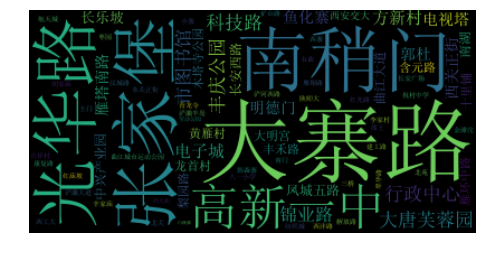

In [24]:
mytext = ' '.join(data_new['place'])
wordcloud = WordCloud(font_path="simsun.ttf").generate(mytext)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 小结
#### 从词云上看出:
-  地点频率排在前列的有：南稍门,大寨路,张家堡,光华路,高新一中
-  大寨路, 光华路, 高新一中 三地位于雁塔区,雁塔区房源总数最多,此三处占总数的30%
-  南稍门位于碑林区. 雁塔区总房源是碑林总房源的5.5倍,表明碑林区房源较为集中, 且大多数位于南稍门
-  张家堡位于未央区, 未央区总房源量中等,其中处于张家堡的房源占到1/5

### 3.3 寻找每个区域性价比最高的小区

对于很多租房者而言, 通常会选择朝向为南北,不为毛坯房,性价比较高的整租房,因此,在原始数据中选择出:
- 朝向为:朝南或者南北
- 租房类型:整租
- 装修程度:不为毛坯

In [25]:
#选择符合条件的数据
data_select = data_new[(data_new['decoration']!='毛坯')&((data_new['direction']=='朝南')|(data_new['direction']=='南北'))\
                       &(data_new['rent_type']=='整租')]

找出性价比最高小区的思路:

1. 使用单位租金(租金/面积)更好的表示性价比
2. 按照区域分组,比如先找出莲湖区数据
3. 在莲湖区数据中,按照小区分组,求出单位租金的中位数(部分房源面积很大或租金很高,异常值较多,中位数比平均值更好的呈现数据情况)
4. 按照单位租金排序,找出最低的前5个小区

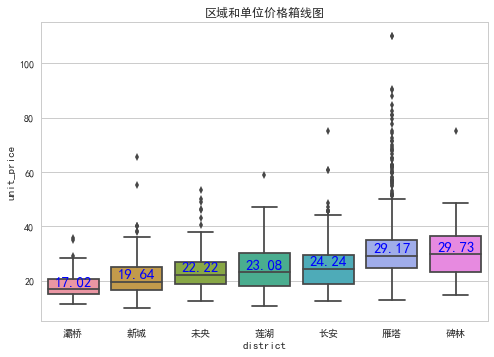

In [26]:
medians = data_select.groupby('district')['unit_price'].median().sort_values(ascending = True).values
order = data_select.groupby('district')['unit_price'].median().sort_values(ascending = True).index
sns.boxplot(data_select['district'],data_select['unit_price'],order=order)
for x,y in zip(np.arange(len(medians)),medians):
    plt.text(x,y+0.5,'%.2f'%y,ha='center',va = 'bottom',fontsize = 15,color='b')
plt.title('区域和单位价格箱线图')    

plt.show()

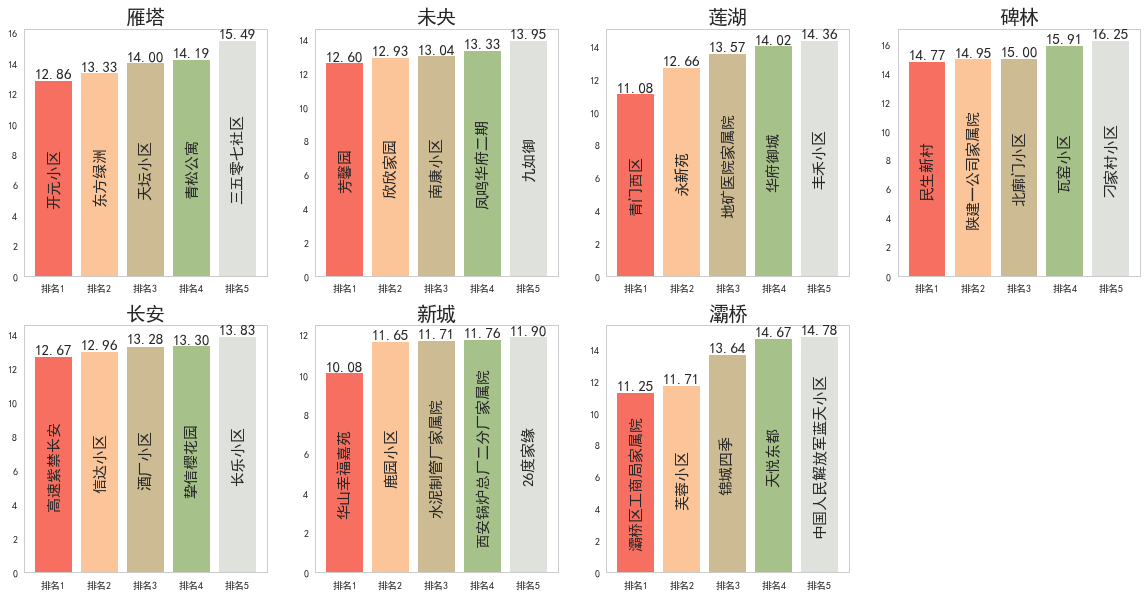

In [27]:
fig4 = plt.figure(figsize = (20,10))

for i in range(1,len(district_house_number)+1):
    ax=fig4.add_subplot(2,4,(i))
    f = data_select[data_select['district']==district_house_number.index[i-1]].groupby('community')['unit_price'].median().sort_values()[:5]
    ax.bar(np.arange(len(f.index)),f.values,color=['#F76F60','#FBC599','#CDBB93','#A7C18B','#DFE2DC'])
    ax.set_xticks(np.arange(len(f.index)))
    ax.set_xticklabels([('排名'+str(s+1)) for s in np.arange(len(f.index))])
    ax.set_title(district_house_number.index[i-1],fontsize=20)
    ax.grid(False)
    for x, y in zip(np.arange(len(f.index)),f.values):
        plt.text(x,y+0.05,'%.2f'%y,ha='center',va = 'bottom',fontsize = 15)
        plt.text(x,y/2,f.index[x],ha='center',va='center',fontsize = 15,rotation = 90)
#     print(district_house_number.index[i-1],f.index[0],int(round(f.values[0]*90,0)))
plt.show()

### 小结

- 符合条件房源中位数最低为灞桥区,90m<sup>2</sup>租金为1532元,房源中位数最高为碑林区,90m<sup>2</sup>租金为2675元
- 得到每个区域性价比最高的小区 :

|区域|中位数最低小区名称| 90m<sup>2</sup>租金(元/月)|
|----|--------------|--------------------------:|
|雁塔|开元小区| 1157|
|未央 |芳馨园 |1134|
|莲湖| 青门西区 |997|
|碑林 |民生新村| 1329|
|长安| 高速紫禁长安 |1140|
|新城 |华山幸福嘉苑 |907|
|灞桥| 灞桥区工商局家属院 |1012|


## 4. 思考与总结

- 大量房源集中在雁塔区
- 大多数房源租金在1000-3000元/月
- 大多数房源面积在30-120m2
- 整租房在雁塔区和未央区较多,合租房在雁塔区和碑林区较多
- 整租房租金约为合租房的3倍
- 中等装修和简单装修租金中位数一致
- 面积开方和租金对数直接存在极其强相关关系
- 碑林区将近50%房源集中在南稍门, 未央区有1/5房源处于张家堡
- 符合条件房源性价比最高位于灞桥区,性价比最低位于碑林区
- 各区域性价比小区为:雁塔-开元小区,未央-芳馨园,莲湖-青门西区,碑林-民生新村,长安-高速紫禁长安,新城-华山幸福嘉苑,灞桥-灞桥区工商局家属院


1. 对于租房的分析是比较简陋的，在本次分析过程中，仅针对房源信息做出描述性分析
2. 租房要考虑的因素不止这些,还要考虑家电,前景,距离公司位置,小区满意度,物业服务等多个因素
3. 直接按照区域分组寻找性价比小区,但并不合理,最好可以加入商圈维度,按照商圈维度分组,计算出小区至商圈的距离以及小区周边商圈个数来分析

## 5.特别说明
- 此为爬取安居客网站前50页内容,区域不够全面
- 原数据存在同一房屋不同名称的房源, 数据处理过程未做分析
- 原数据中存在合租房错写为整租的房源,未作处理
- 寻找性价比高的小区时,主观选择了南北朝向和不为毛坯房的整租房,略显草率

- 难免存在不足和纰漏，希望能给出意见和建议


ps:转载请联系作者